In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# import the dataset 
df = pd.read_csv(r"C:\Users\dhanu\OneDrive\Documents\books academic\p-1\datasets\creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# checking for NULL (empty) values in the dataset

df.isnull().sum().to_frame().T

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


No NULL or empty values present in the dataset. Free to explore the data.

#### Few points to consider before working on the data :
Data is already undergone through PCA (principal component analysis) to reduce the dimensionality required to train the model. All the columns are already scaled/standardized except time and amount. Class column is already binarized to 1s and 0s, 1 indicating that it is a fraud transaction and 0 indicating that it is a normal transaction.



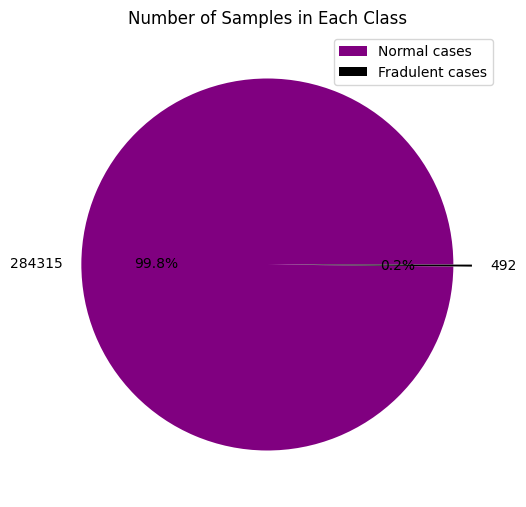

Percentage of Fraud Samples: 0.1727485630620034


In [4]:
# Let's visualize some data : EDA

data_x = [0,1]
y_1 = df[df["Class"] == 1]
y_0 = df[df["Class"] == 0]
data_y = [len(y_0), len(y_1)]

plt.figure(figsize=(6,7))
wedges, _, __ = plt.pie(data_y, explode = [0,0.1],colors = ["purple", "black"], labels = data_y,autopct =  '%1.1f%%')
custom = ["Normal cases", "Fradulent cases"]

plt.title('Number of Samples in Each Class')
plt.legend(wedges, custom, loc = "upper right")
plt.show()

print(f"Percentage of Fraud Samples: {(len(y_1)/df.shape[0])*100}")

As we can see from this plot, the fraud samples are very low in number (around 0.172%). Directly using this data will cause the model to wrongly classify all fraud cases as normal transactions. Basically, the model will not reach the sensitivity for detecting fraud samples properly.

In [5]:
Fraud = df[df["Class"] == 1]
Normal = df[df["Class"] == 0]

print(f"Average Time taken for Fraud cases: {Fraud['Time'].mean()}")
print(f"Average Time taken for Normal cases: {Normal['Time'].mean()}\n")

print(f"Average Amount from Fraud cases: {Fraud['Amount'].mean()}")
print(f"Average Amount from Normal cases: {Normal['Amount'].mean()}")


Average Time taken for Fraud cases: 80746.80691056911
Average Time taken for Normal cases: 94838.20225805884

Average Amount from Fraud cases: 122.21132113821139
Average Amount from Normal cases: 88.29102242231328


Time taken for Normal cases is comparatively higher than fraud case. Amount taken in Fraud transactions (on average) is higher. These can be some signs for properly detecting fraud samples.


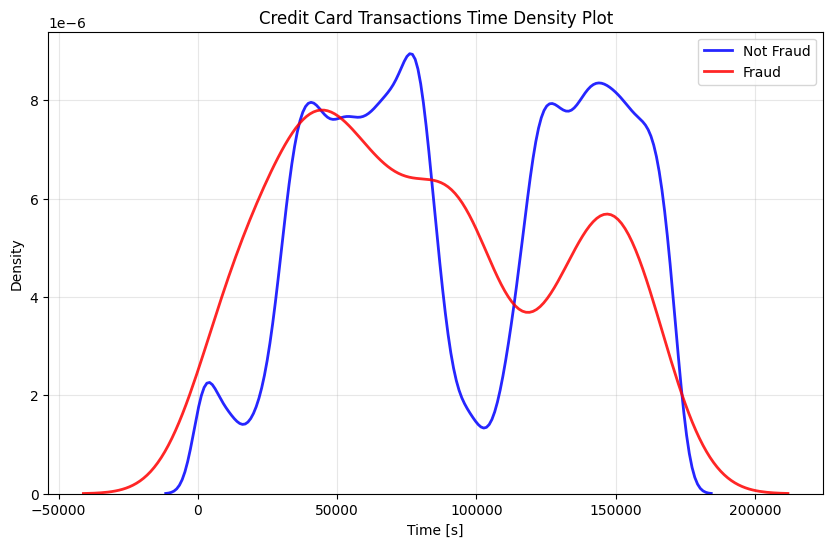

In [6]:
# Plotting the distribution of time for transactions for separate classes, to check the concentration of transactions with time

class_0 = df.loc[df['Class'] == 0, "Time"]
class_1 = df.loc[df['Class'] == 1, "Time"]

plt.figure(figsize=(10, 6))  

# plotting density plot for normal transactions
sns.kdeplot(class_0, label='Not Fraud', lw = 2,  color='blue', alpha=0.85)

# plottting density plot for fradulent transactions 
sns.kdeplot(class_1, label='Fraud', lw = 2,  color='red', alpha=0.85)

plt.title('Credit Card Transactions Time Density Plot')
plt.xlabel('Time [s]')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3) 

plt.show()



As we can see from the plot, Normal transactions were fairly distributed among 2 days (because people don't do much transactions at night time). But for Fraud transactions, we can see the concentration/frequency of transactions, regardless of hour of the day, is consistent and continuous. We can't exactly classify all night time transactions as fraud, but we can identify the trend at which Fraud transactions occur. This is an useful insight.

Let's do some feature engineering.
Using the Time column is pretty confusing, since it is showing time in seconds, which we can convert it into hours, so that we can visualize how many transactions occur per hour, and what percentage are fraud or not. 

In [7]:
# create a new column named "hour"
df["hour"] = df["Time"].apply(lambda x : np.floor(x/3600))

# storing statistical information in a temporary variable
tmp = df.groupby(["hour", "Class"])["Amount"].aggregate(["min","max","sum","count","mean","median","var"]).reset_index()  # reset_index to keep it as a Dataframe

# change the columns names, but first reintialize it as a DataFrame again
temp_df = pd.DataFrame(tmp)
temp_df.columns = ["hour","Class", "min","max","Sum", "Transactions", "Mean", "Median", "Variance"]
temp_df.head(7)



,hour,Class,min,max,Sum,Transactions,Mean,Median,Variance
0,0.0,0,0.0,7712.43,256572.87,3961,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,529.00,2,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,145806.76,2215,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,298.93,2,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,106989.39,1555,68.803466,17.900,45355.430437
5,2.0,1,1.0,1809.68,1829.78,21,87.132381,1.000,155776.441219
6,3.0,0,0.0,1903.26,94086.79,1808,52.039154,15.950,16741.786661


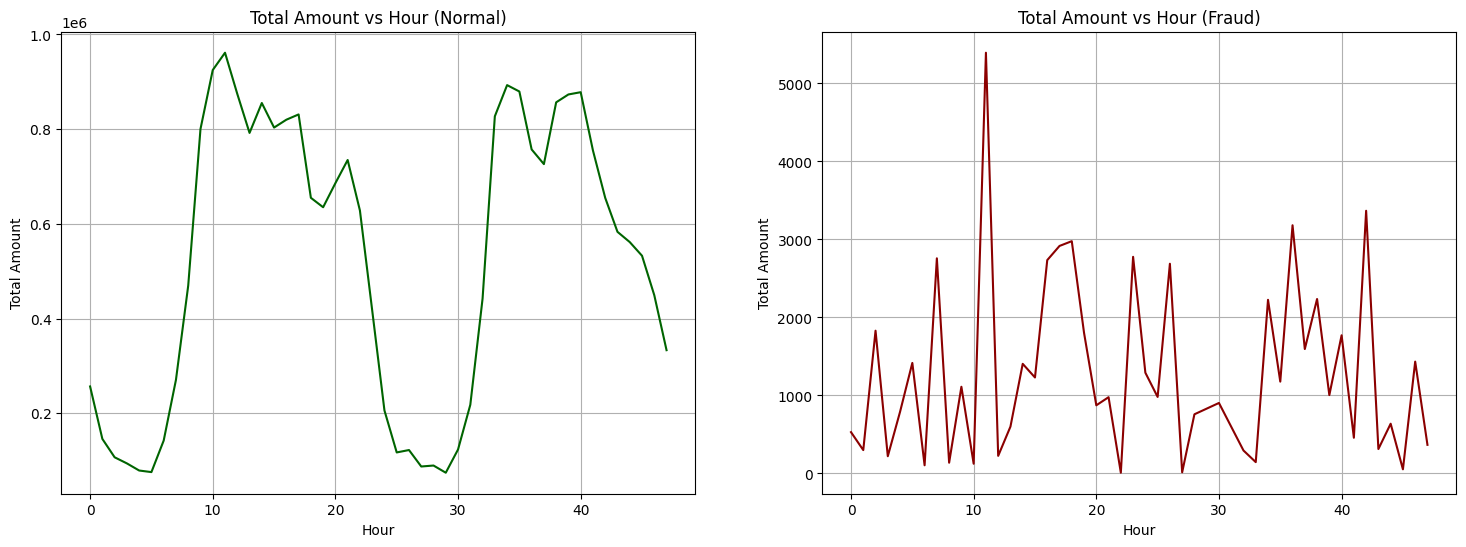

In [8]:
# now let's use this new information to visualize the data to see what the data tells us


# plotting total sum of transactions per hour for Normal and Fraud transactions
fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize = (18,6))

ax1.plot(temp_df.loc[temp_df.Class == 0, "hour"], temp_df.loc[temp_df.Class == 0, "Sum"], label = "Normal Transactions", color = "darkgreen")
ax1.set_title("Total Amount vs Hour (Normal)")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Total Amount")
ax1.grid(True)

ax2.plot(temp_df.loc[temp_df.Class == 1,"hour"], temp_df.loc[temp_df.Class == 1, "Sum"], label = "Fraud Transactions", color = "darkred")
ax2.set_title("Total Amount vs Hour (Fraud)")
ax2.set_xlabel("Hour")
ax2.set_ylabel("Total Amount")
ax2.grid(True)



In this plot, we can observe that, for normal transactions, the overall amount wired is a lot higher compared to transactions due to fraud. Whereas the amount of transactions in Fraud is almost below 5000 (Currency Units). But based on the frequency of the transactions that occur, we can observe a pattern. High number of transactions are only observed during the day time, and we can see a dip in the amount of transactions that occur during night time. In Fraud cases, we cannot find this similar trend, hence distinction is noted.


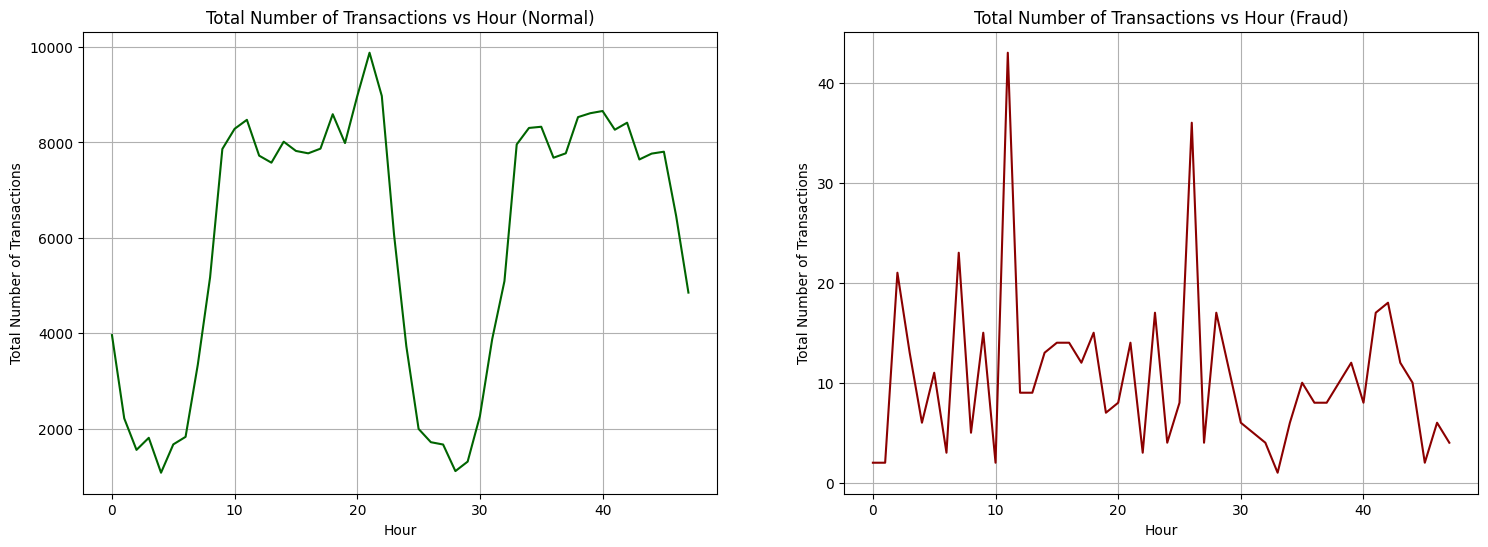

In [9]:
# plotting total number of transactions per hour for Normal and Fraud transactions

fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize = (18,6))

ax1.plot(temp_df.loc[temp_df.Class == 0, "hour"], temp_df.loc[temp_df.Class == 0, "Transactions"], label = "Normal Transactions", color = "darkgreen")
ax1.set_title("Total Number of Transactions vs Hour (Normal)")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Total Number of Transactions")
ax1.grid(True)

ax2.plot(temp_df.loc[temp_df.Class == 1,"hour"], temp_df.loc[temp_df.Class == 1, "Transactions"], label = "Fraud Transactions", color = "darkred")
ax2.set_title("Total Number of Transactions vs Hour (Fraud)")
ax2.set_xlabel("Hour")
ax2.set_ylabel("Total Number of Transactions")
ax2.grid(True)

Even if we look at the y-axis of both the plots here, the number of transactions in Normal case is very high (around 6000), but we can also see the range of times that these transactions occur. This doesn't happen for Fraud cases, number of transactions can be comparatively low, because of the unbalanced dataset (only 492 different class samples), but still, the transaction patterns still remain the same.

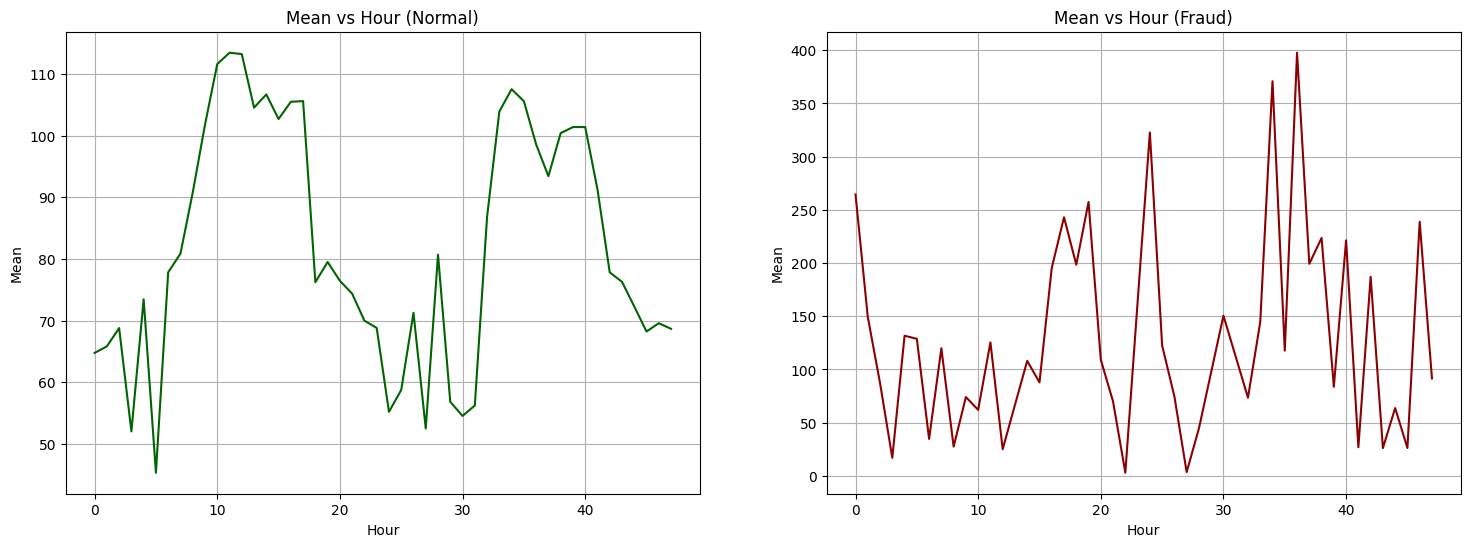

In [10]:
fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize = (18,6))

ax1.plot(temp_df.loc[temp_df.Class == 0, "hour"], temp_df.loc[temp_df.Class == 0, "Mean"], label = "Normal Transactions", color = "darkgreen")
ax1.set_title("Mean vs Hour (Normal)")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Mean")
ax1.grid(True)

ax2.plot(temp_df.loc[temp_df.Class == 1,"hour"], temp_df.loc[temp_df.Class == 1, "Mean"], label = "Fraud Transactions", color = "darkred")
ax2.set_title("Mean vs Hour (Fraud)")
ax2.set_xlabel("Hour")
ax2.set_ylabel("Mean")
ax2.grid(True)

In this plot also, we can observe the average amount of transactions is higher for Fraud cases compared to Normal cases. And also high variance is observed in Fraud data samples.
But we can't blindly assume that high transaction amount is definitely fraud, since there are transaction amounts within normal range also in Fraud case.


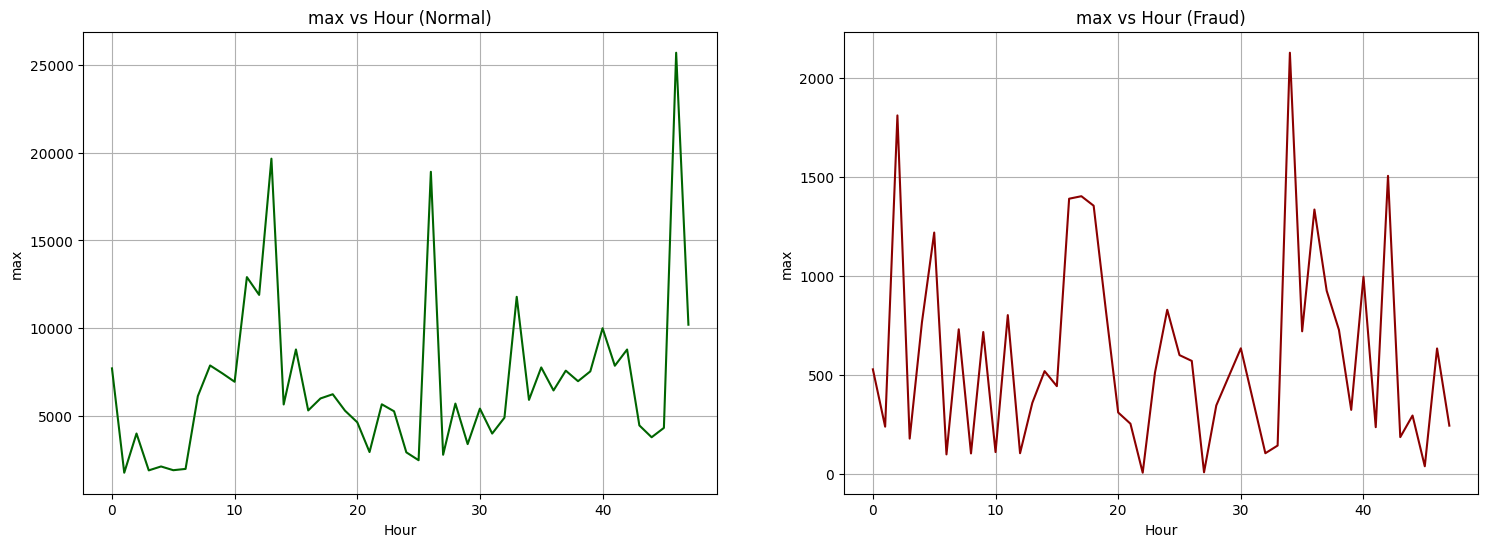

In [11]:
fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize = (18,6))

ax1.plot(temp_df.loc[temp_df.Class == 0, "hour"], temp_df.loc[temp_df.Class == 0, "max"], label = "Normal Transactions", color = "darkgreen")
ax1.set_title("max vs Hour (Normal)")
ax1.set_xlabel("Hour")
ax1.set_ylabel("max")
ax1.grid(True)

ax2.plot(temp_df.loc[temp_df.Class == 1,"hour"], temp_df.loc[temp_df.Class == 1, "max"], label = "Fraud Transactions", color = "darkred")
ax2.set_title("max vs Hour (Fraud)")
ax2.set_xlabel("Hour")
ax2.set_ylabel("max")
ax2.grid(True)

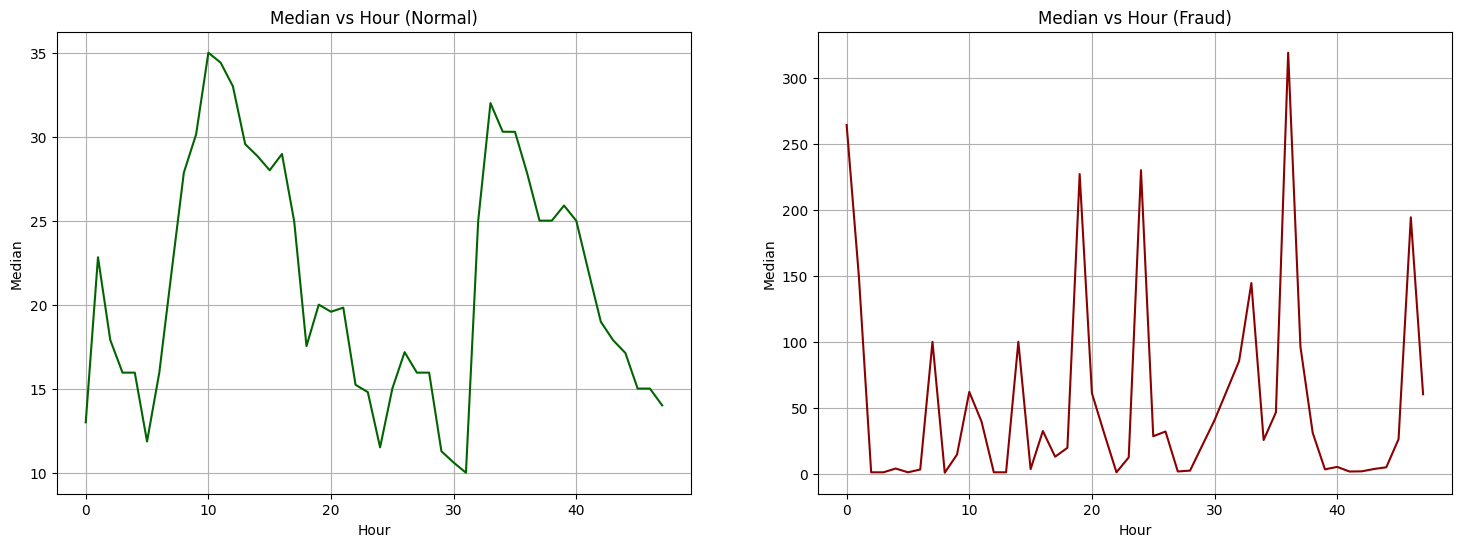

In [12]:
fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize = (18,6))

ax1.plot(temp_df.loc[temp_df.Class == 0, "hour"], temp_df.loc[temp_df.Class == 0, "Median"], label = "Normal Transactions", color = "darkgreen")
ax1.set_title("Median vs Hour (Normal)")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Median")
ax1.grid(True)

ax2.plot(temp_df.loc[temp_df.Class == 1,"hour"], temp_df.loc[temp_df.Class == 1, "Median"], label = "Fraud Transactions", color = "darkred")
ax2.set_title("Median vs Hour (Fraud)")
ax2.set_xlabel("Hour")
ax2.set_ylabel("Median")
ax2.grid(True)

This plot reveals one more insight about the transaction types. For Normal transactions, the median is fairly consistent and we can observe a clear range where the median varies. But for Fraud transactions, we can see that the median is mostly close to 0 (minimum), and there is a spike in the median at certain times of hours. But we can also observe some median values which are very low, meaning Fraud transactions won't always occur at a higher amount, but also can occur at low or medium range of transaction amount. 

This explains that the data from Fraud samples is highly skewed and contains a lot of outliers in the data.

C:\Users\dhanu\AppData\Local\Temp\ipykernel_13704\2602861777.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([Normal_amt, Fraud_amt], labels = ["Normal", "Fraud"], showfliers = True)
C:\Users\dhanu\AppData\Local\Temp\ipykernel_13704\2602861777.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([Normal_amt, Fraud_amt], labels = ["Normal", "Fraud"], showfliers = False)


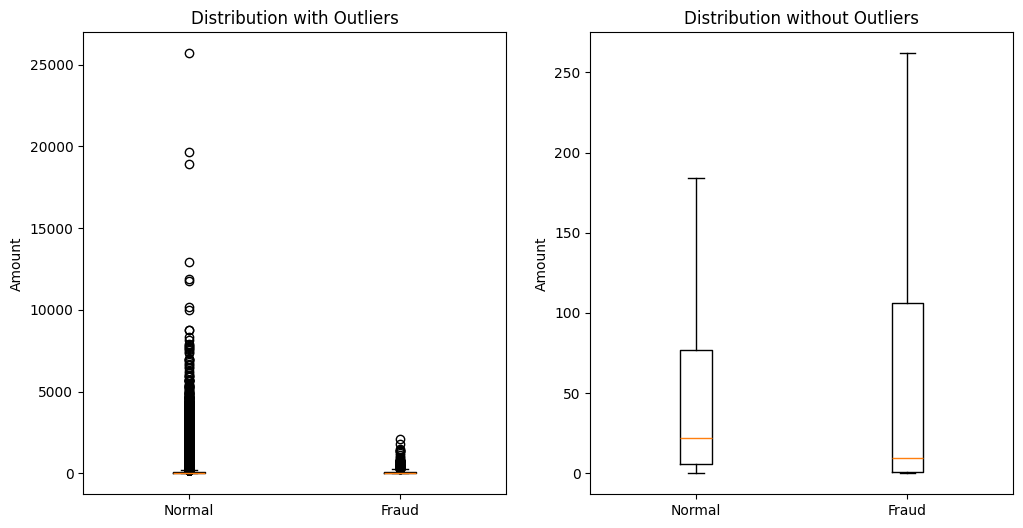

In [13]:
# let's see the distribution of the data based on mean and variance

Fraud_amt = Fraud['Amount']
Normal_amt = Normal["Amount"]

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12,6))

ax1.boxplot([Normal_amt, Fraud_amt], labels = ["Normal", "Fraud"], showfliers = True)
ax1.set_title("Distribution with Outliers")
ax1.set_ylabel("Amount")

ax2.boxplot([Normal_amt, Fraud_amt], labels = ["Normal", "Fraud"], showfliers = False)
ax2.set_title("Distribution without Outliers")
ax2.set_ylabel("Amount")

plt.show()

In [14]:
Fraud_amt.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [15]:
Normal_amt.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

The mean, Q1 is larger for normal samples compared to fraud samples, and also the outliers for normal samples are far higher and spread out more, compared to fraud samples where the outliers are not spread out much and the overall range is not very high either.



In [16]:
import plotly.express as px   # for interactive plots
import plotly.io as pio       # for interacting with the plots
pio.renderers.default = 'browser'


fig = px.scatter(
    Fraud, x = 'Time', y = 'Amount',
    title = 'Amount of Fraudulent Transactions',
    opacity = 0.5, color_discrete_sequence = ['red'],
    hover_data = ["Time", "Amount"]
)
fig.show()

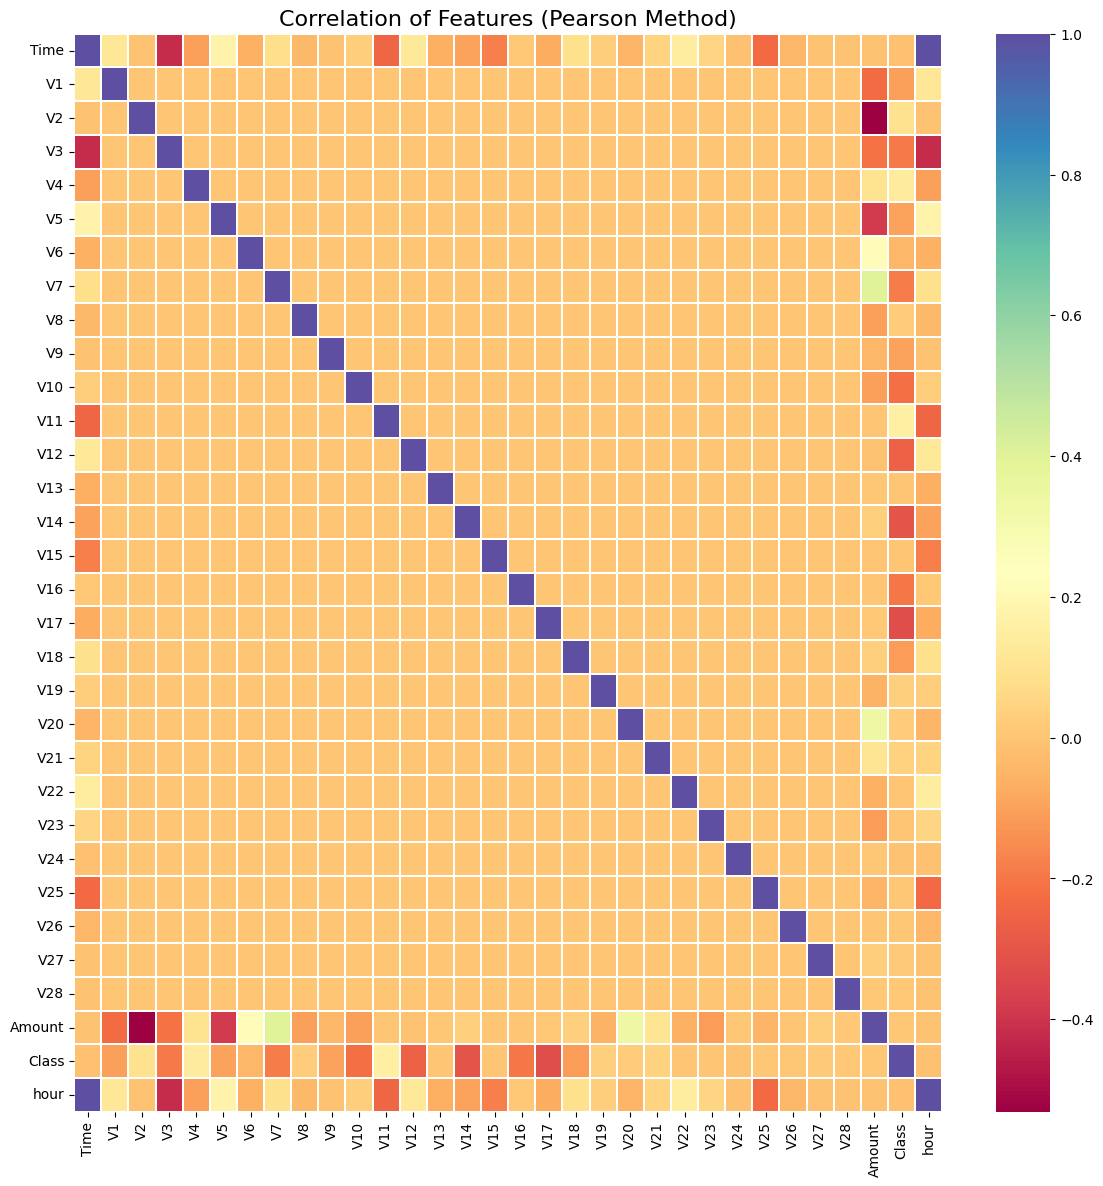

In [17]:
# plotting features that depend on other features and target column, using correlation matrix and heatmap

plt.figure(figsize=(14,14))
plt.title("Correlation of Features (Pearson Method)", fontsize = 16)

corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.1, cmap = 'Spectral')
plt.show()

Most faetures from V1 to V28 don't have any strong correlation with each other. Columns like time and amount have some features which are directly correlated and some which are inversely correlated.  

Amount : direct correlation (V7, V20) ; inverse correlation (V1,V2,V5)  
Time : inverse correlation (V3,V11,V15,V25)
